In [1]:
library('ggplot2')
library('readr')
library('repr')
library('dplyr')

source('common_stats_functions.r')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: sp
rgdal: version: 1.4-7, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.3, released 2019/10/28
 Path to GDAL shared files: /usr/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.2.1, November 1st, 2019, [PJ_VERSION: 620]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields


Regions defined for each Polygons


In [2]:
fe_dom_re <- read_csv(paste0(dn_path,'sensitivity_analysis/fixed_randomDomain_effects.csv'))
station_fe_re <- read_csv(paste0(dn_path, 'sensitivity_analysis/randomStation_summedeffects.csv'))

#Rename domains for plotting
station_fe_re <- rename_domains_for_plotting(station_fe_re)
fe_dom_re <- rename_domains_for_plotting(fe_dom_re)
# Reorder levels by domain precip amounts
station_fe_re <- transform(station_fe_re, neonDomainName=reorder(neonDomainName, MAPdom))
fe_dom_re <- transform(fe_dom_re, neonDomainName=reorder(neonDomainName, MAPdom))

Parsed with column specification:
cols(
  neonDomainName = col_character(),
  MAP = col_double(),
  MAT = col_double(),
  spei12mo_trend = col_double(),
  spei12mo_cv5yr_trend = col_double(),
  ndvi_prcp_Intcpt = col_double(),
  ndvi_prcp_Slope = col_double(),
  zndvi_prcp_Intcpt = col_double(),
  zndvi_prcp_Slope = col_double(),
  zndvi_spei_Intcpt = col_double(),
  zndvi_spei_Slope = col_double(),
  MAPdom = col_double(),
  MATdom = col_double(),
  spei12mo_trend_all = col_double(),
  spei12mo_cv5yr_trend_all = col_double()
)
Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  neonDomainName = col_character()
)
See spec(...) for full column specifications.


In [3]:
# Get a dataset that has domain and random effects without fixed for plotting
dom_re <- fe_dom_re[fe_dom_re$neonDomainName!='FixedEffects',]
# Also get a color scheme for domains sorted by map
library('RColorBrewer')
cols <- colorRampPalette(brewer.pal(11,"Spectral"))
myPal <- cols(17)

[1] 0.000539297

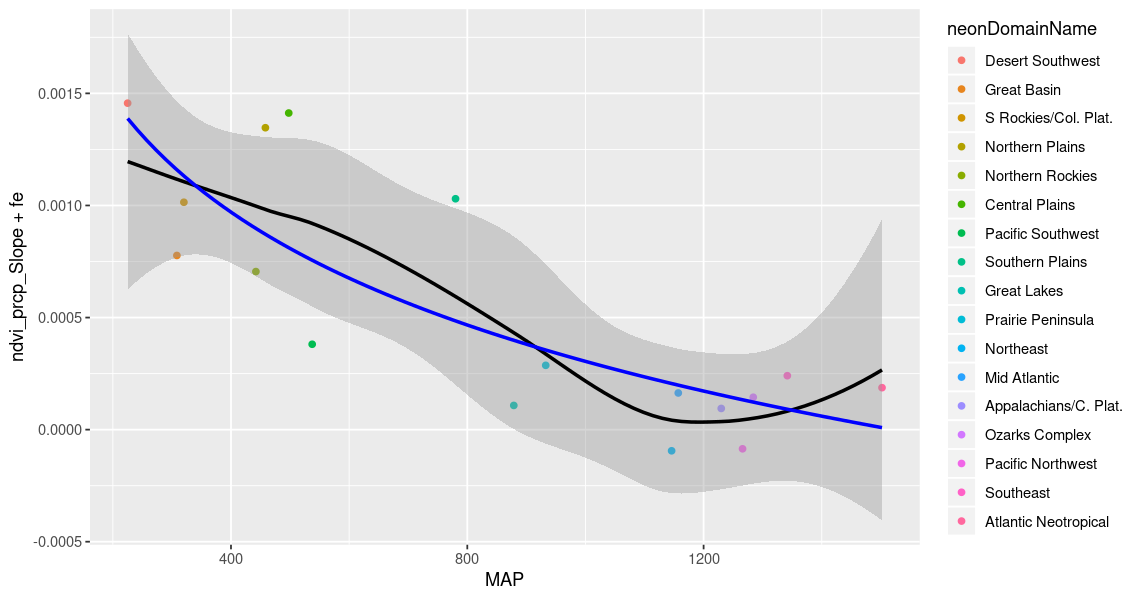

In [4]:
options(repr.plot.width=9.5, repr.plot.height=5)
# Plots of the domain slopes (fixed effect + random domain effect)
fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','ndvi_prcp_Slope'][[1]]
fe

exp.model <-lm((ndvi_prcp_Slope + fe) ~ exp(-MAP), dom_re)
exp.model.df <- data.frame(x = dom_re$MAP,
                           y = fitted(exp.model))

ggplot(dom_re, aes(x=MAP, y=ndvi_prcp_Slope + fe, col=neonDomainName)) +
    geom_point() + geom_smooth(method='loess', col='black') + 
    geom_smooth(method='glm', formula=(y ~ exp(log(x)/100000)), se=FALSE, col='blue')
    #geom_line(data = exp.model.df, aes(x, y, color = "Log Model"), size = 1, linetype = 2)

In [5]:
max(station_fe_re$ndvi_prcp_randomSlope, na.rm=TRUE)*1000
min(station_fe_re$ndvi_prcp_randomSlope, na.rm=TRUE)*1000

[1] 1.814352

[1] -0.2988565


Call:
glm(formula = (ndvi_prcp_randomSlope * 1000) + 0.4 ~ exp(-MAP/1000), 
    family = Gamma(link = "log"), data = station_fe_re)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7093  -0.2902  -0.0556   0.1857   1.1298  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.39156    0.02954  -47.11   <2e-16 ***
exp(-MAP/1000)  2.53245    0.05829   43.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.1430127)

    Null deviance: 435.12  on 1161  degrees of freedom
Residual deviance: 176.38  on 1160  degrees of freedom
  (46 observations deleted due to missingness)
AIC: 495.86

Number of Fisher Scoring iterations: 4


[1] 46

[1] 0.3896015

[1] 0.7593405

[1] 0.1843649

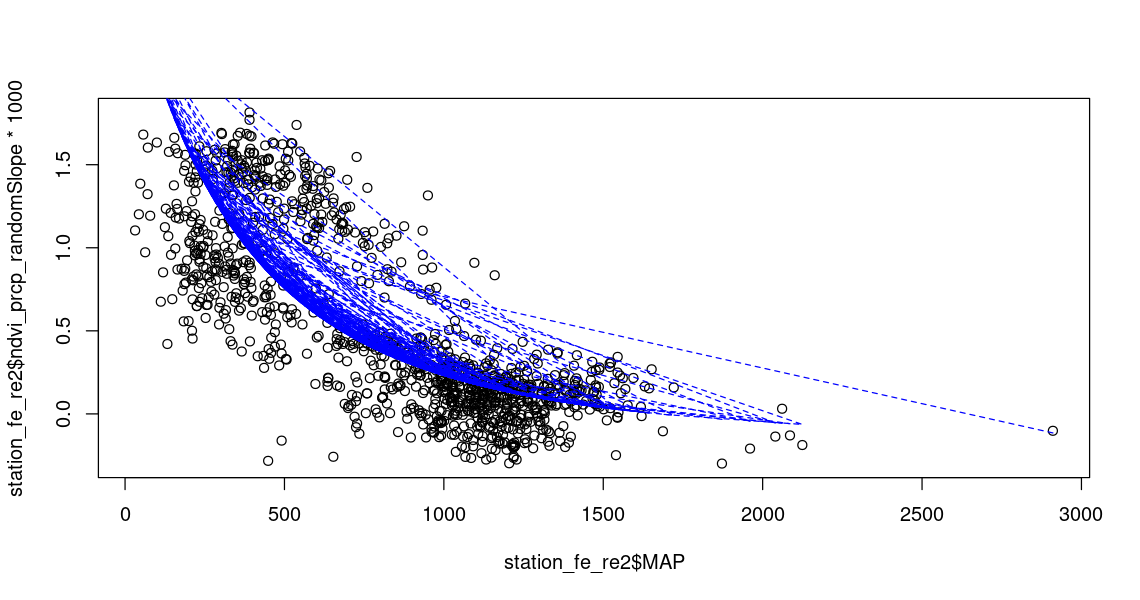

In [6]:
# Fit an exponential model to the ALL data that can be plotted 
set.seed(101)     # so the example is reproduceable

#fit <- glm((ndvi_prcp_randomSlope*1000)+0.4 ~ exp(-MAP/1000),data=station_fe_re )
# Gamma link function fits better but fails with negative values
# Adjusting the y values (+0.4) helps, but its then hard to plot.... - fitted values must be adjusted
fit <- glm((ndvi_prcp_randomSlope*1000)+0.4 ~ exp(-MAP/1000), family=Gamma(link='log'), data=station_fe_re )#,

summary(fit)

sum(is.na(station_fe_re$ndvi_prcp_randomSlope))
naidx <- is.na(station_fe_re$ndvi_prcp_randomSlope)

station_fe_re2 <- station_fe_re
station_fe_re2$pred_nlinALL[!naidx] <- fitted(fit)
#station_fe_re2$pred_nlinALL[naidx] <- fitted(fit, newdata=data.frame(MAP=station_fe_re2$MAP[naidx]))
plot(station_fe_re2$MAP,station_fe_re2$ndvi_prcp_randomSlope*1000)
lines(station_fe_re2$MAP,station_fe_re2$pred_nlinALL-0.4, col="blue",lty=2)
# RMSE
sqrt(mean(residuals(fit)^2))
#NRMSE 1
(sqrt(mean(residuals(fit)^2)))/(mean(station_fe_re2$ndvi_prcp_randomSlope, na.rm=TRUE)*1000)
#NRMSE 2
diff2 <- (max(station_fe_re2$ndvi_prcp_randomSlope, na.rm=TRUE) - min(station_fe_re2$ndvi_prcp_randomSlope, na.rm=TRUE)) * 1000
(sqrt(mean(residuals(fit)^2)))/diff2

In [7]:
#plot(fit)

Loading required package: rcompanion


$Models
  Call                                                                   
1 "glm(formula = (ndvi_prcp_randomSlope * 1000) + 0.4 ~ exp(-MAP/1000), "

$Fit.criteria
  Min.max.accuracy   MAE  MAPE   MSE  RMSE NRMSE.mean NRMSE.median
1            0.754 0.277 0.378 0.141 0.375      0.411        0.543
  NRMSE.mean.accuracy NRMSE.median.accuracy Efron.r.squared CV.prcnt
1               0.589                 0.457            0.52     41.1

$Models
                                                                                                         
Model: "glm, (ndvi_prcp_randomSlope * 1000) + 0.4 ~ exp(-MAP/1000), Gamma(link = \"log\"), station_fe_re"
Null:  "glm, (ndvi_prcp_randomSlope * 1000) + 0.4 ~ 1, Gamma(link = \"log\"), station_fe_re"             

$Pseudo.R.squared.for.model.vs.null
                             Pseudo.R.squared
McFadden                             0.690346
Cox and Snell (ML)                   0.609311
Nagelkerke (Cragg and Uhler)         0.819296

$Likelihood.ratio.test
 Df.diff LogLik.diff  Chisq     p.value
      -1     -546.05 1092.1 1.7221e-239

$Number.of.observations
           
Model: 1162
Null:  1162

$Messages
[1] "Note: For models fit with REML, these statistics are based on refitting with ML"

$Warnings
[1] "None"

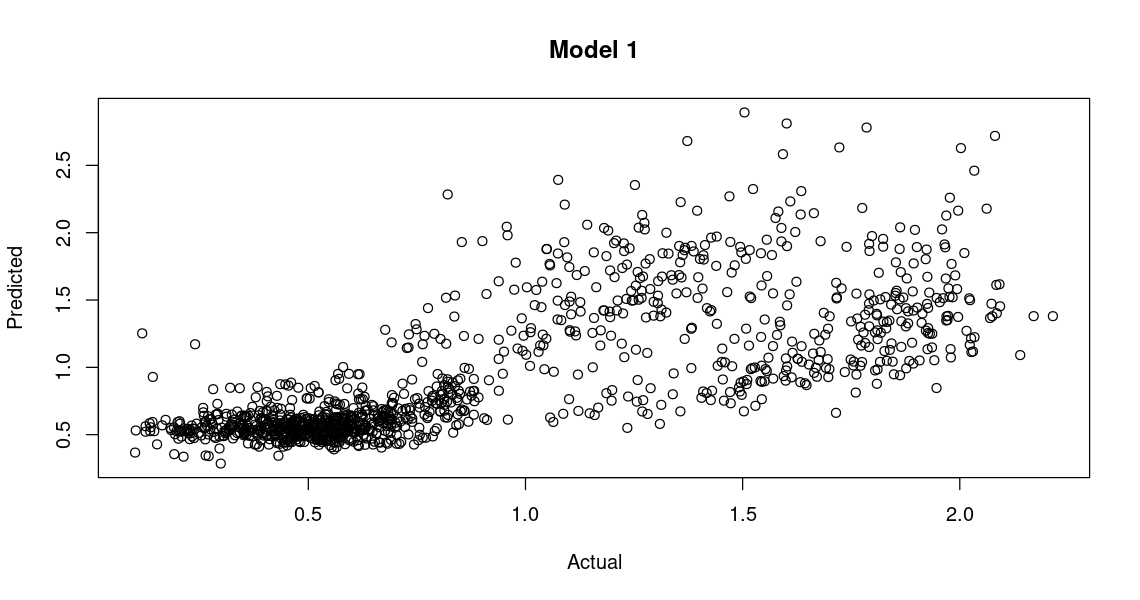

In [8]:
# Get some pseudo-R2 values
require('rcompanion')
accuracy(list(fit))
nagelkerke(fit)

Warning message in log(ndvi_prcp_randomSlope):
“NaNs produced”


Call:
lm(formula = log(ndvi_prcp_randomSlope) ~ MAP, data = station_fe_re)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6690 -0.3477  0.0931  0.5126  1.6981 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.160e+00  5.754e-02 -107.06   <2e-16 ***
MAP         -2.265e-03  6.545e-05  -34.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8294 on 997 degrees of freedom
  (209 observations deleted due to missingness)
Multiple R-squared:  0.5458,	Adjusted R-squared:  0.5454 
F-statistic:  1198 on 1 and 997 DF,  p-value: < 2.2e-16


Warning message in log(station_fe_re2$ndvi_prcp_randomSlope):
“NaNs produced”

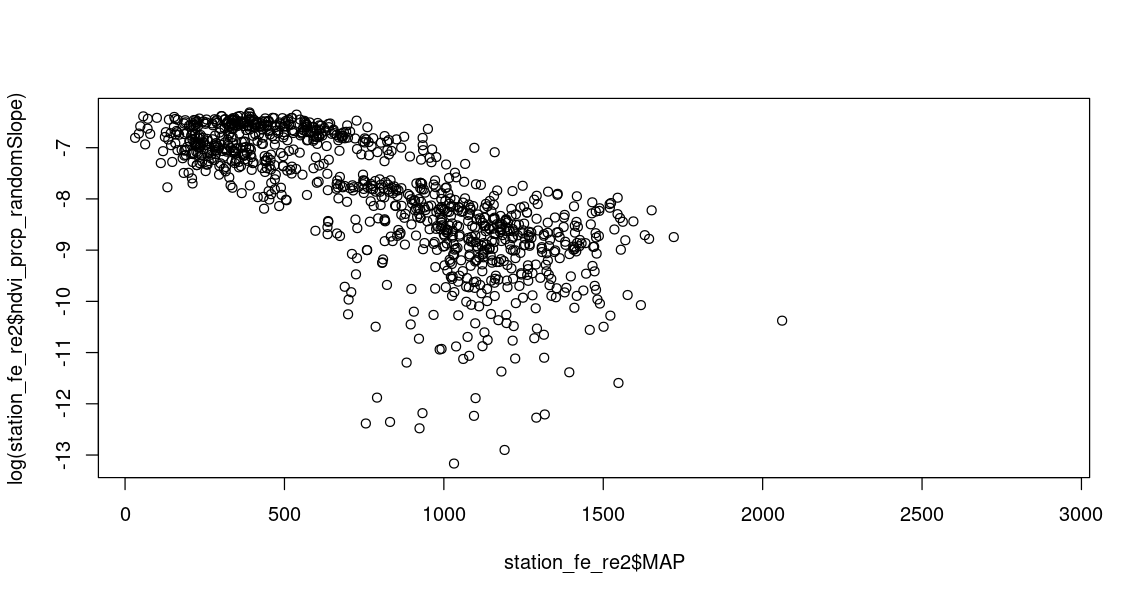

In [9]:
# Log transform and calculate an R2 with lm
fit2 <- lm(log(ndvi_prcp_randomSlope) ~ MAP,data=station_fe_re )#,
summary(fit2)
plot(station_fe_re2$MAP, log(station_fe_re2$ndvi_prcp_randomSlope))
#plot(fit2)

In [10]:
levels(station_fe_re$neonDomainName)

[1] "Desert Southwest"      "Great Basin"           "S Rockies/Col. Plat." 
 [4] "Northern Plains"       "Northern Rockies"      "Central Plains"       
 [7] "Pacific Southwest"     "Southern Plains"       "Great Lakes"          
[10] "Prairie Peninsula"     "Northeast"             "Mid Atlantic"         
[13] "Appalachians/C. Plat." "Ozarks Complex"        "Pacific Northwest"    
[16] "Southeast"             "Atlantic Neotropical"

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_smooth).”Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_smooth).”Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_smooth).”

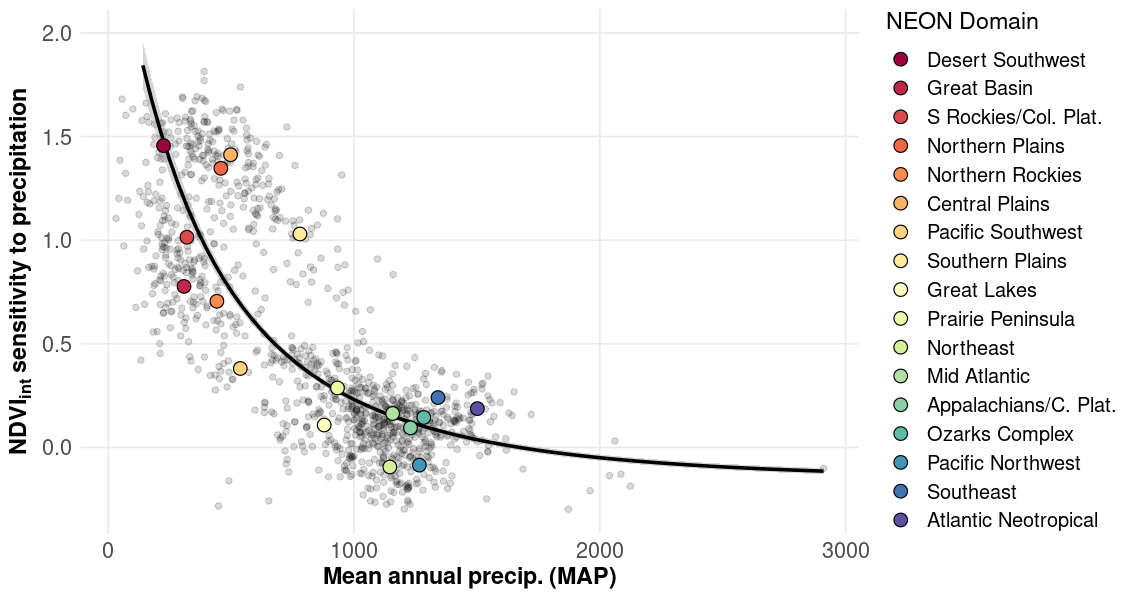

In [11]:
yaxlab <- expression(atop("NDVI:Precip", "(", italic("NDVI sum per meter precipitation"), ")"))

ggplot(station_fe_re, aes(x=MAP, y=ndvi_prcp_randomSlope*1000)) +
    geom_point(alpha=0.15) +
    # See model results above - second one fits better
    #geom_smooth(method='glm', formula=(y ~ exp(-x/1000)), se=TRUE, col='red') +
    geom_smooth(method='glm', method.args=list(family=Gamma(link='log')), formula=(y+0.4 ~ exp(-x/1000)), 
                position = position_nudge(y = -0.4), se=TRUE, col='black') +
    ylab(expression(bold(NDVI[int] * ' sensitivity to precipitation'))) + ylim(-0.3,2) + #\n(summed NDVI/meter precip)') +
    xlab('Mean annual precip. (MAP)') +
    theme_minimal() + theme(panel.grid.minor=element_blank(),axis.text=element_text(size=13),
                            axis.title=element_text(size=14,face="bold"),
                            legend.title=element_text(size=14),legend.text=element_text(size=12)) +
    guides(fill=guide_legend(title='NEON Domain')) +
    geom_point(aes(x=MAP, y=(ndvi_prcp_Slope + fe)*1000, fill=neonDomainName), shape=21, col='black', size=3.5, data=dom_re) +
    scale_fill_manual(values=myPal)# + 
#geom_smooth(aes(x=MAP, y=ndvi_prcp_Slope + fe), data=fe_dom_re, method='loess', col='blue')

ggsave('../figs/ndviprecipSens_vs_MAP.pdf', width=8, height=5)
ggsave('../figs/ndviprecipSens_vs_MAP.png', width=8, height=5, dpi=600)

[1] 0.003772118

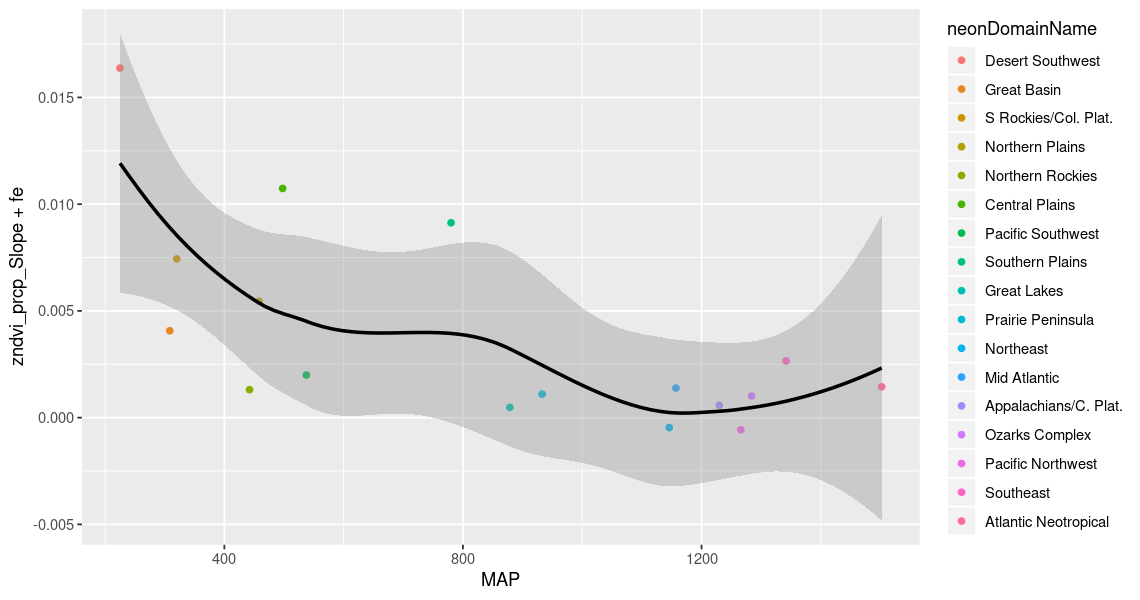

In [12]:
# Plots of the domain slopes (fixed effect + random domain effect)
fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','zndvi_prcp_Slope'][[1]]
fe
ggplot(dom_re, aes(x=MAP, y=zndvi_prcp_Slope + fe, col=neonDomainName)) +
    geom_point() + geom_smooth(method='loess', col='black')

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

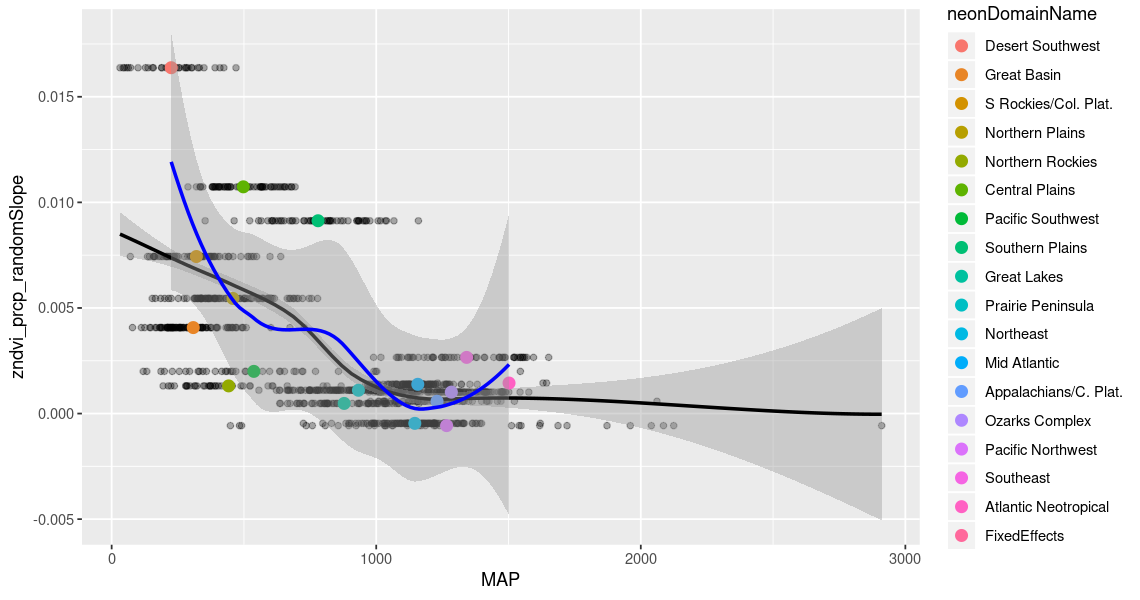

In [13]:
ggplot(station_fe_re, aes(x=MAP, y=zndvi_prcp_randomSlope)) +
    geom_point(alpha=0.3) + geom_smooth(method='loess', col='black') +
    geom_point(aes(x=MAP, y=zndvi_prcp_Slope + fe, col=neonDomainName), size=3, data=fe_dom_re) + 
    geom_smooth(aes(x=MAP, y=zndvi_prcp_Slope + fe), data=dom_re, method='loess', col='blue')

# Station random effects are very small here. it may not make much sense to calculated
# sensitivity of zndvi to precipitation (one standardized, the other not)

[1] 1.385812

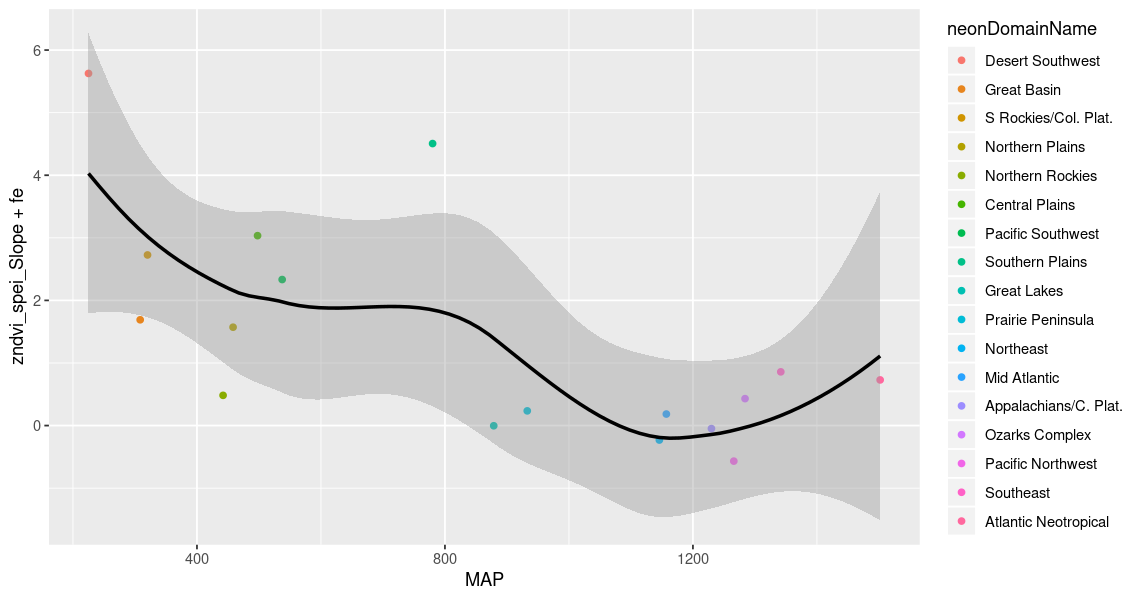

In [14]:
# Plots of the domain slopes (fixed effect + random domain effect)
fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','zndvi_spei_Slope'][[1]]
fe
ggplot(dom_re, aes(x=MAP, y=zndvi_spei_Slope + fe, col=neonDomainName)) +
    geom_point() + geom_smooth(method='loess', col='black')


Call:
glm(formula = zndvi_spei_randomSlope + 2 ~ exp(-MAP/1000), family = Gamma(link = "log"), 
    data = station_fe_re)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6006  -0.2523  -0.1210   0.1096   1.4119  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.30009    0.03110   9.651   <2e-16 ***
exp(-MAP/1000)  1.69011    0.06137  27.542   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.1585131)

    Null deviance: 276.10  on 1161  degrees of freedom
Residual deviance: 151.95  on 1160  degrees of freedom
  (46 observations deleted due to missingness)
AIC: 3355.1

Number of Fisher Scoring iterations: 4


[1] 46

[1] 0.3616181

[1] 0.3146071

[1] 0.03575558

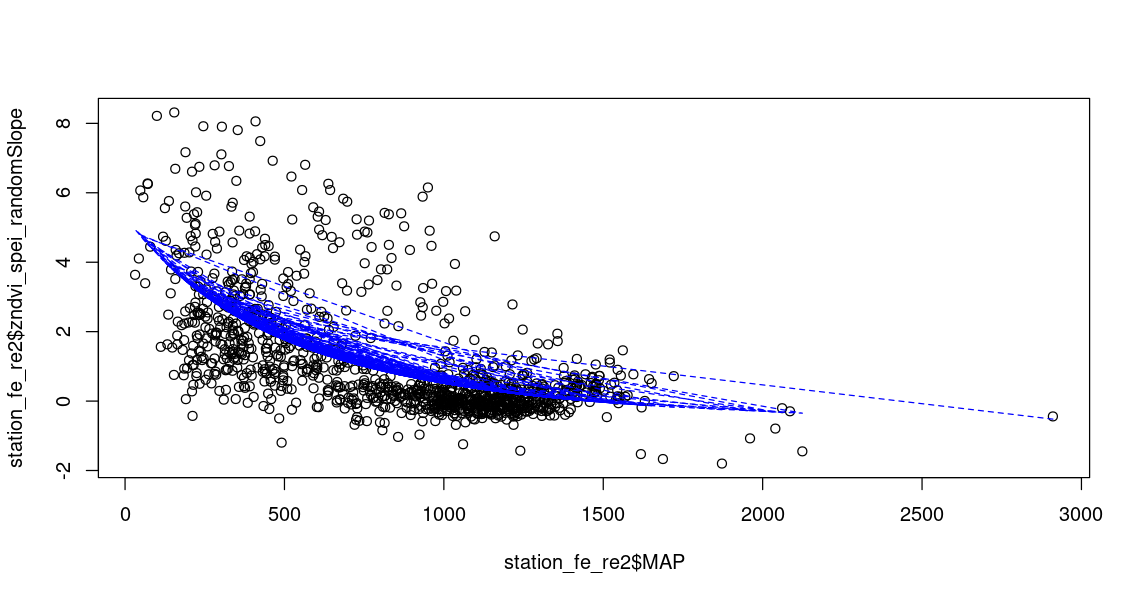

In [15]:
set.seed(1)     # so the example is reproduceable

#fit <- glm(zndvi_spei_randomSlope+2 ~ exp(-MAP/1000), data=station_fe_re)
# Gamma link function fits a little better but fails with negative values
# Adjusting the y values (+2) helps, but its then hard to plot.... - fitted values must be adjusted
fit <- glm(zndvi_spei_randomSlope+2 ~ exp(-MAP/1000), family=Gamma(link='log'), data=station_fe_re)#,

summary(fit)

sum(is.na(station_fe_re$zndvi_spei_randomSlope))
naidx <- is.na(station_fe_re$zndvi_spei_randomSlope)

station_fe_re2 <- station_fe_re
station_fe_re2$pred_nlinALL[!naidx] <- fitted(fit)
#station_fe_re2$pred_nlinALL[naidx] <- fitted(fit, newdata=data.frame(MAP=station_fe_re2$MAP[naidx]))
plot(station_fe_re2$MAP,station_fe_re2$zndvi_spei_randomSlope)
lines(station_fe_re2$MAP,station_fe_re2$pred_nlinALL -2, col="blue",lty=2)
#RMSE
sqrt(mean(residuals(fit)^2))
#NRMSE 1
(sqrt(mean(residuals(fit)^2)))/(mean(station_fe_re2$zndvi_spei_randomSlope, na.rm=TRUE))
#NRMSE 2
diff2 <- (max(station_fe_re2$zndvi_spei_randomSlope, na.rm=TRUE) - min(station_fe_re2$zndvi_spei_randomSlope, na.rm=TRUE))
(sqrt(mean(residuals(fit)^2)))/diff2

In [16]:
#plot(fit)

$Models
  Call                                                                                         
1 "glm(formula = zndvi_spei_randomSlope + 2 ~ exp(-MAP/1000), family = Gamma(link = \"log\"), "

$Fit.criteria
  Min.max.accuracy  MAE  MAPE  MSE RMSE NRMSE.mean NRMSE.median
1            0.777 0.91 0.303 1.78 1.33      0.424        0.547
  NRMSE.mean.accuracy NRMSE.median.accuracy Efron.r.squared CV.prcnt
1               0.576                 0.453           0.388     42.4

$Models
                                                                                               
Model: "glm, zndvi_spei_randomSlope + 2 ~ exp(-MAP/1000), Gamma(link = \"log\"), station_fe_re"
Null:  "glm, zndvi_spei_randomSlope + 2 ~ 1, Gamma(link = \"log\"), station_fe_re"             

$Pseudo.R.squared.for.model.vs.null
                             Pseudo.R.squared
McFadden                             0.175848
Cox and Snell (ML)                   0.459338
Nagelkerke (Cragg and Uhler)         0.473683

$Likelihood.ratio.test
 Df.diff LogLik.diff  Chisq    p.value
      -1     -357.29 714.58 2.015e-157

$Number.of.observations
           
Model: 1162
Null:  1162

$Messages
[1] "Note: For models fit with REML, these statistics are based on refitting with ML"

$Warnings
[1] "None"

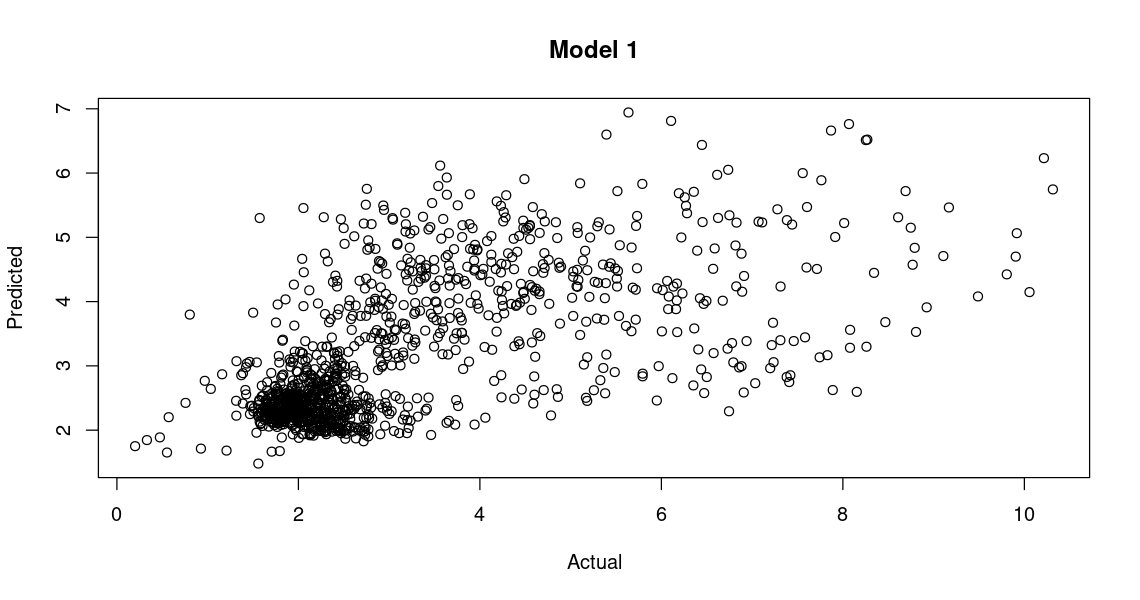

In [17]:
# Pseudo-R2
accuracy(list(fit))
nagelkerke(fit)

Warning message in log(zndvi_spei_randomSlope):
“NaNs produced”


Call:
lm(formula = log(zndvi_spei_randomSlope) ~ MAP, data = station_fe_re)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4023 -0.5823  0.0991  0.7228  2.6649 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.316e+00  8.100e-02   16.25   <2e-16 ***
MAP         -2.090e-03  9.549e-05  -21.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.146 on 860 degrees of freedom
  (346 observations deleted due to missingness)
Multiple R-squared:  0.3578,	Adjusted R-squared:  0.3571 
F-statistic: 479.2 on 1 and 860 DF,  p-value: < 2.2e-16


Warning message in log(station_fe_re2$zndvi_spei_randomSlope):
“NaNs produced”

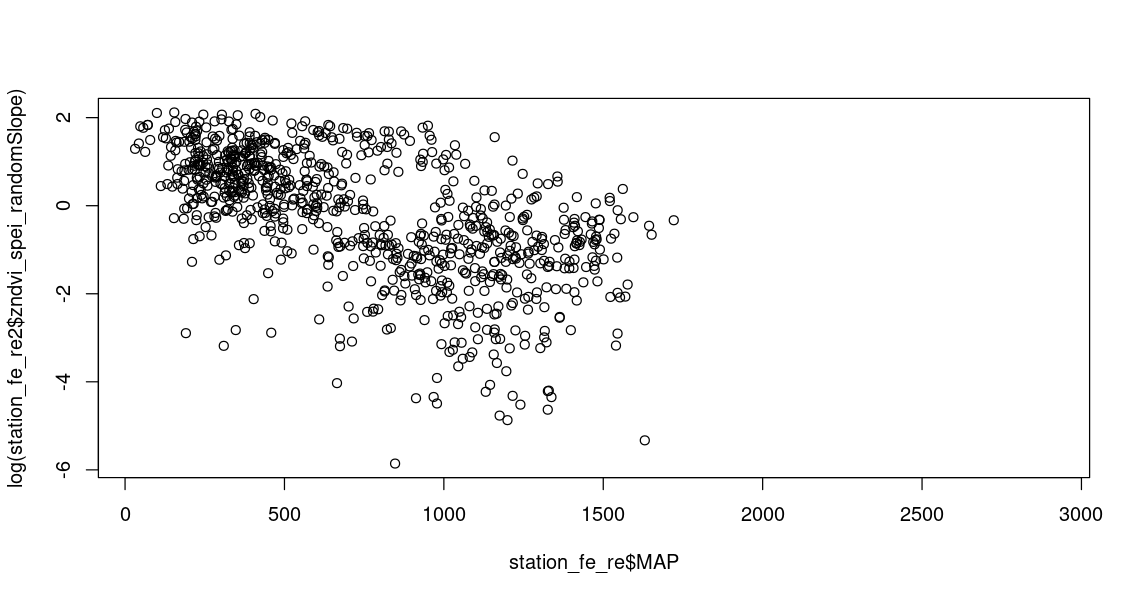

In [18]:
# Log transform and calculate an R2 with lm
fit2 <- lm(log(zndvi_spei_randomSlope) ~ MAP,data=station_fe_re )
summary(fit2)
plot(station_fe_re$MAP, log(station_fe_re2$zndvi_spei_randomSlope))
#plot(fit2)

Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”Warning message:
“Removed 46 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 46 rows containing missing values (geom_point).”

[1] 1.385812

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

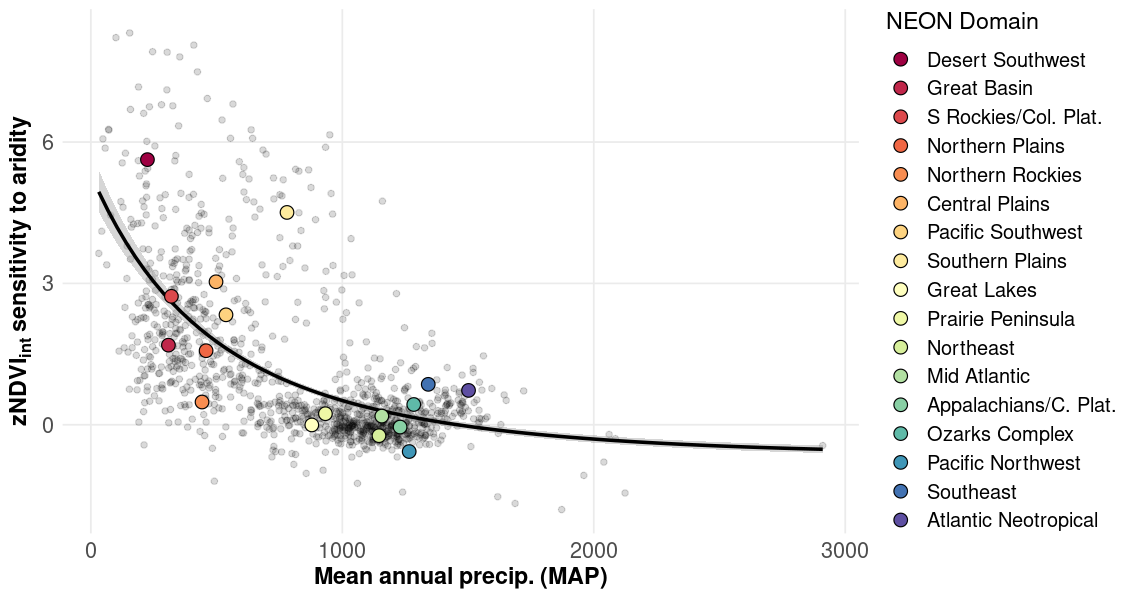

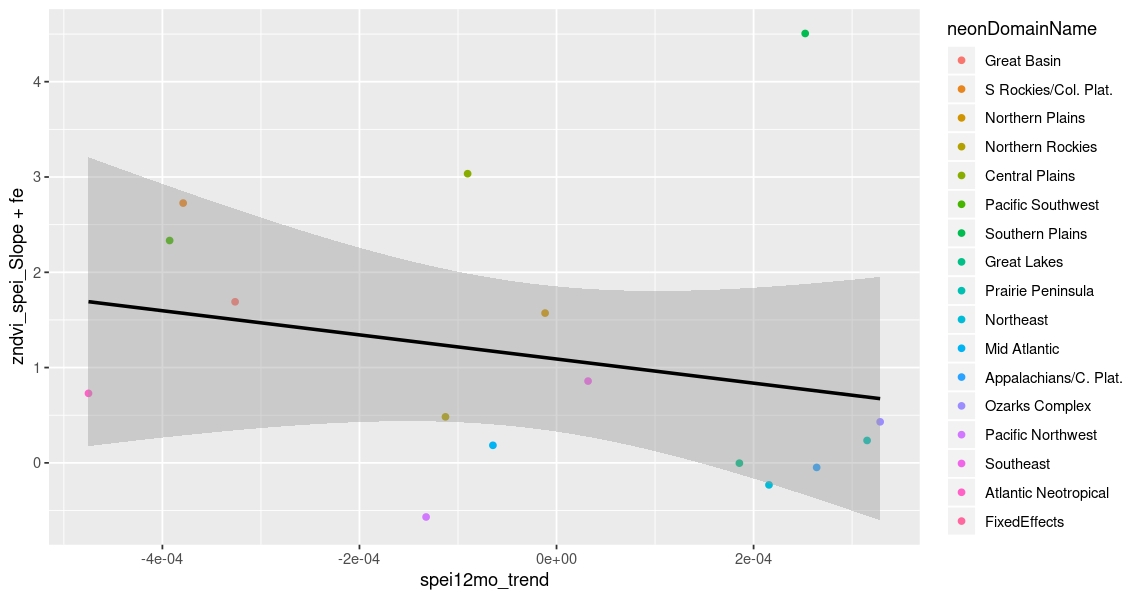

In [19]:
ggplot(station_fe_re, aes(x=MAP, y=zndvi_spei_randomSlope)) +
    geom_point(alpha=0.15) +
    # See model results above - second model fits better
    #geom_smooth(method='glm', formula=(y ~ exp(-x/1000)), se=TRUE, col='red') + # 0 + exp... makes asymptote==0
    geom_smooth(method='glm', method.args=list(family=Gamma(link='log')), formula=(y+2 ~ exp(-x/1000)), 
                position = position_nudge(y = -2), se=TRUE, col='black') +
    ylab(expression(bold(zNDVI[int] * ' sensitivity to aridity'))) +
    xlab('Mean annual precip. (MAP)') +
    theme_minimal() + theme(panel.grid.minor=element_blank(),axis.text=element_text(size=13),
                            axis.title=element_text(size=14,face="bold"),
                            legend.title=element_text(size=14),legend.text=element_text(size=12)) +
    guides(fill=guide_legend(title='NEON Domain')) +
    geom_point(aes(x=MAP, y=zndvi_spei_Slope + fe, fill=neonDomainName), shape=21, col='black', size=3.5, data=dom_re) +
    scale_fill_manual(values=myPal)# + 
    #geom_smooth(aes(x=MAP, y=zndvi_spei_Slope + fe), data=fe_dom_re, method='loess', col='blue')

ggsave('../figs/zndvispeiSens_vs_MAP.pdf', width=8, height=5)
ggsave('../figs/zndvispeiSens_vs_MAP.png', width=8, height=5, dpi=600)

fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','zndvi_spei_Slope'][[1]]
fe
test <- subset(fe_dom_re, neonDomainName!='Desert Southwest')
ggplot(test, aes(x=spei12mo_trend, y=zndvi_spei_Slope + fe, col=neonDomainName)) +
    geom_point() + geom_smooth(method='lm', col='black')

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

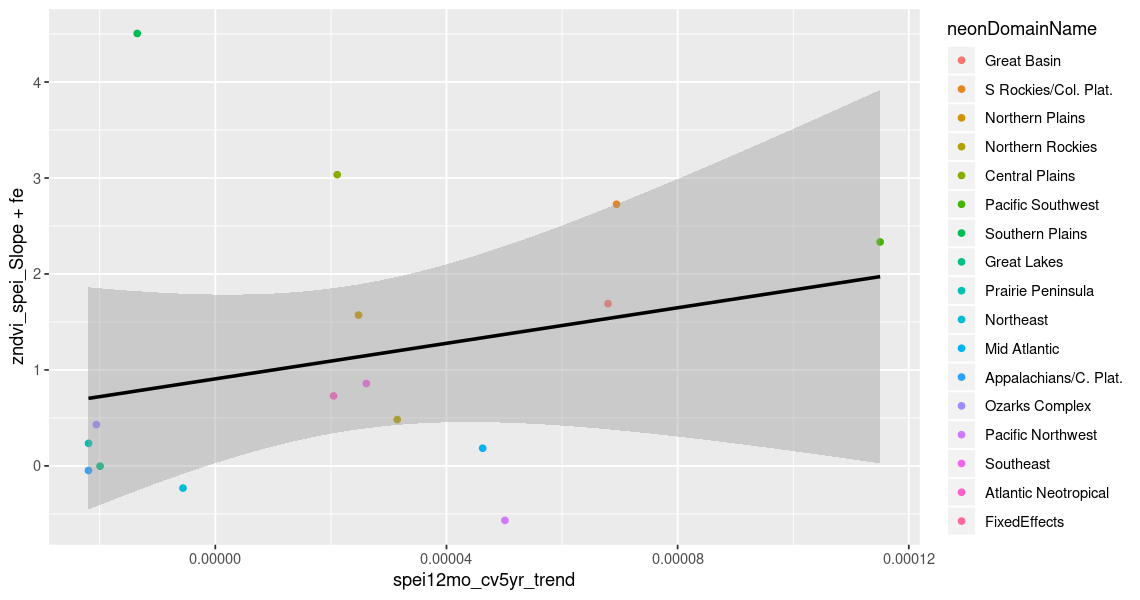

In [20]:
ggplot(test, aes(x=spei12mo_cv5yr_trend, y=zndvi_spei_Slope + fe, col=neonDomainName)) +
    geom_point() + geom_smooth(method='lm', col='black')